In [43]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## ImageDataGenerator: Batches of tensor image data with real-time data augmentation

In [44]:
CAT_SOURCE_DIR = "./PetImages/Cat"
DOG_SOURCE_DIR = "./PetImages/Dog/"
TRAINING_DIR = "./cats-v-dogs/training/"
VALIDATION_DIR = "./cats-v-dogs/validation/"
TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")
TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

In [45]:
def train_val_generators(training_dir, validation_dir):
    """
    Creates the training and validation data generators
    Args:
    training_dir (string): directory path containing the training images
    validation_dir (string): directory path containing the testing/validation images
    Returns:
    train_generator, validation_generator - tuple containing the generators
    """

    # Instantiate the ImageDataGenerator class
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    # train_datagen.flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=training_dir,
                                                        batch_size=10,
                                                        class_mode='binary',
                                                        target_size=(150, 150))

    # Instantiate the ImageDataGenerator class
    validation_datagen = ImageDataGenerator(rescale=1/255)

    # flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                  batch_size=10,
                                                                  class_mode='binary',
                                                                  target_size=(150, 150))
    return train_generator, validation_generator

In [46]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [47]:
images, labels = next(train_generator)
print('batch size =', len(labels), labels)

batch size = 10 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Transfer learning

Download the `inception V3` weights: https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

Load the InceptionV3 model and save the path to the weights.

In [48]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

## Pre-trained model

In [49]:
def create_pre_trained_model(local_weights_file):
    """
    Initializes an InceptionV3 model.
    Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file
    Returns:
    pre_trained_model: the initialized InceptionV3 model
    """
    pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                    include_top = False,
                                    weights = None)

    pre_trained_model.load_weights(local_weights_file)

    # Make all the layers in the pre-trained model non-trainable
    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model

In [50]:
pre_trained_model = create_pre_trained_model(local_weights_file)

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [51]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params} total parameters in this model.")
print(f"There are {num_trainable_params} trainable parameters in this model.")

There are 21802784 total parameters in this model.
There are 0 trainable parameters in this model.


## Callback

In [52]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.999:
            print("Reached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

## Pipelining the Pre-trained model

Use the mixed7 layer as the last layer of the pre-trained model

In [53]:
def output_of_last_layer(pre_trained_model):
    """
    Gets the last layer output of a model
    Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from
    Returns:
    last_output: output of the model's last layer
    """
    last_desired_layer = pre_trained_model.get_layer('mixed7')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)

    return last_output

In [54]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


## Tensorflow's Functional API

Adding additional layers on top of the pre-trained model.

In [55]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [61]:
def create_final_model(pre_trained_model, last_output):
    """
    Appends a custom model to a pre-trained model
    Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model
    Returns:
    model: the combined model
    """
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)
    # Fully connected layer with 1024 hidden units and ReLU activation
    x = layers.Dense(units=1024, activation='relu')(x)
    # Dropout rate of 0.2
    x = layers.Dropout(0.2)(x)
    # Sigmoid layer for classification
    x = layers.Dense(1, activation='sigmoid')(x)

    # Create the complete model by using the Model class
    model = Model(inputs=pre_trained_model.input, outputs=x)

    # Compile the model
    model.compile(optimizer = RMSprop(learning_rate=0.0001),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])

    return model

In [62]:
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params} total parameters in this model.")
print(f"There are {num_trainable_params} trainable parameters in this model.")

There are 47512481 total parameters in this model.
There are 38537217 trainable parameters in this model.


In [66]:
callbacks = MyCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 5,
                    callbacks=callbacks)

Epoch 1/5
270/270 [==============================] - 134s 497ms/step - loss: 0.2658 - accuracy: 0.9100 - val_loss: 0.0888 - val_accuracy: 0.9700
Epoch 2/5
270/270 [==============================] - 132s 489ms/step - loss: 0.2483 - accuracy: 0.9233 - val_loss: 0.1375 - val_accuracy: 0.9567
Epoch 3/5
270/270 [==============================] - 134s 495ms/step - loss: 0.2288 - accuracy: 0.9274 - val_loss: 0.0761 - val_accuracy: 0.9700
Epoch 4/5
270/270 [==============================] - 133s 492ms/step - loss: 0.2144 - accuracy: 0.9341 - val_loss: 0.1827 - val_accuracy: 0.9533
Epoch 5/5
270/270 [==============================] - 134s 495ms/step - loss: 0.2158 - accuracy: 0.9367 - val_loss: 0.0488 - val_accuracy: 0.9767


## Model training history

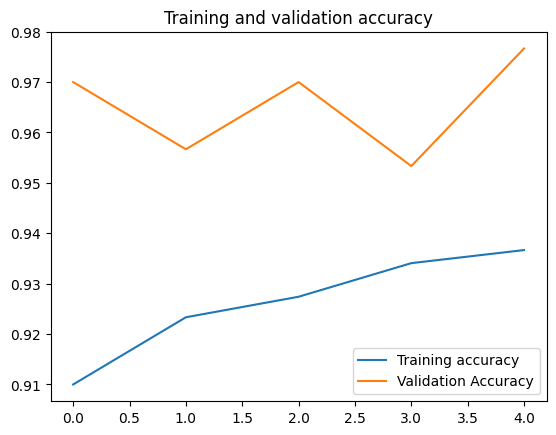

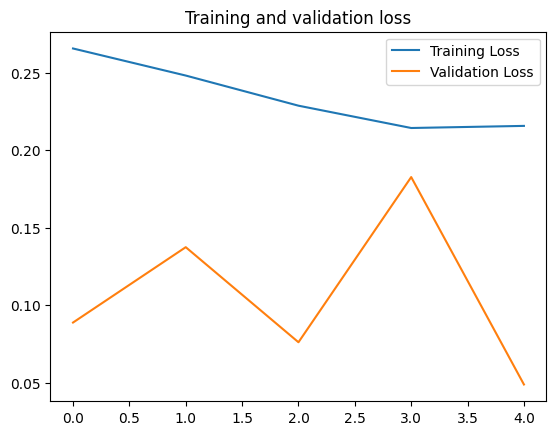

In [67]:
def plot_acc_val(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss' ]
    epochs = range(len(acc)) # Get number of epochs

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_acc_val(history)